In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
def load_metric(expdir, metric='loss', split='tr', meta=True):
    if meta:
        tr = np.load(expdir + '/meta_{}_{}.npy'.format(split, metric))
    else:
        tr = np.load(expdir + '/{}_{}.npy'.format(split, metric))
    return tr[tr>0]

def smooth(arr, r):
    r = int(r)
    smoothed = np.zeros(len(arr))
    for i in range(len(arr) // r):
        chunk = arr[i*r:i*r+r]
        avg = np.sum(chunk) / len(chunk)
        smoothed[i*r:i*r+r] = avg
    return smoothed[smoothed >0]

def bootstrap_ci(data_list, runs, samples=100, ci=95):
    data_mat = np.array(data_list).T
    bootstrapped, low, high, median = [], [], [], []
    
    for idx, l in enumerate(data_mat):
        median.append(np.median(l))
        bootstrap_median_list = []
        for i in range(samples):
            replacement_sample = np.random.choice(l, size=runs)
            m = np.median(replacement_sample)
            bootstrap_median_list.append(m)
        bootstrapped.append(bootstrap_median_list)

    bootstrapped = np.array(bootstrapped)
    for reward in bootstrapped:
        low.append(np.percentile(reward, 100 - ci))
        high.append(np.percentile(reward, ci))

    return low, high, median

In [3]:
plt.rcParams['figure.figsize'] = (20, 8)

def plot_metrics(exp_dir):
    plt.figure()
    
    plt.subplot(1,2,1)
    plt.title('Loss')
    t1, = plt.plot(smooth(load_metric(exp_dir, 'loss', 'tr', meta=False), 100))
    t2, = plt.plot(smooth(load_metric(exp_dir, 'loss', 'val', meta=False), 100))
    t3, = plt.plot(smooth(load_metric(exp_dir, 'loss', 'tr'), 100))
    t4, = plt.plot(smooth(load_metric(exp_dir, 'loss', 'val'), 100))
    plt.ylim((0, 3))
    plt.xlim((0, 10000))


    plt.subplot(1,2,2)
    t1, = plt.plot(smooth(load_metric(exp_dir, 'acc', 'tr', meta=False), 10))
    t2, = plt.plot(smooth(load_metric(exp_dir, 'acc', 'val', meta=False), 10))
    t3, = plt.plot(smooth(load_metric(exp_dir, 'acc', 'tr'), 10))
    t4, = plt.plot(smooth(load_metric(exp_dir, 'acc', 'val'), 10))
    plt.legend([t1, t2, t3, t4], ['train','val', 'm-train', 'm-val'])
    plt.ylim((0, 1.05))
    plt.xlim((0, 10000))
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    
def plot_ci(data, color, label, runs):
    low, median, high = bootstrap_ci(data, runs)
    plt.plot(np.arange(len(median)), median, 'k-', label=label, color=color, linewidth=2)
    plt.fill_between(np.arange(len(median)), low, high, color=color, alpha=0.3)
    return median

def plot_multiple_runs(exp_name, runs, it_limit=2000):
    exp_dirs = [exp_name + '-run{}'.format(i + 1) for i in range(runs)]
    
    # Plotting Loss
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('Loss')
    train_ls = [smooth(load_metric(e, 'loss', 'tr', meta=False)[:it_limit], 10) for e in exp_dirs]
    val_ls = [smooth(load_metric(e, 'loss', 'val', meta=False)[:it_limit], 10) for e in exp_dirs]
    meta_train_ls = [smooth(load_metric(e, 'loss', 'tr')[:it_limit], 10) for e in exp_dirs]
    meta_val_ls = [smooth(load_metric(e, 'loss', 'val')[:it_limit], 10) for e in exp_dirs]
    
    train_ls_median = plot_ci(train_ls, color='r', label='train', runs=5)
    val_ls_median = plot_ci(val_ls, color='b', label='val', runs=5)
    meta_train_ls_median = plot_ci(meta_train_ls, color='g', label='meta-train', runs=5)
    meta_val_ls_median = plot_ci(meta_val_ls, color='m', label='meta-val', runs=5)
    
    plt.legend()
    plt.xlim((0, it_limit))
    
    # Plotting Accuracy
    plt.subplot(1,2,2)
    plt.title('Accuracy')
    plt.xlabel("Iterations")
    train_acc = [smooth(load_metric(e, 'acc', 'tr', meta=False)[:it_limit], 10) for e in exp_dirs]
    val_acc = [smooth(load_metric(e, 'acc', 'val', meta=False)[:it_limit], 10) for e in exp_dirs]
    meta_train_acc = [smooth(load_metric(e, 'acc', 'tr')[:it_limit], 10) for e in exp_dirs]
    meta_val_acc = [smooth(load_metric(e, 'acc', 'val')[:it_limit], 10) for e in exp_dirs]
    
    train_acc_median = plot_ci(train_acc, color='r', label='train', runs=5)
    val_acc_median = plot_ci(val_acc, color='b', label='val', runs=5)
    meta_train_acc_median = plot_ci(meta_train_acc, color='g', label='meta-train', runs=5)
    meta_val_acc_median = plot_ci(meta_val_acc, color='m', label='meta-val', runs=5)
    
    loss_dict = {'train': train_ls_median[-1], 'val': val_ls_median[-1], 'meta_train': meta_train_ls_median[-1], 'meta_val': meta_val_ls_median[-1]}
    acc_dict = {'train': train_acc_median[-1], 'val': val_acc_median[-1], 'meta_train': meta_train_acc_median[-1], 'meta_val': meta_val_acc_median[-1]}
    
    plt.legend()
    plt.xlim((0, it_limit))
    plt.ylim((0., 1.05))
    return loss_dict, acc_dict

# Learning to Transfer Experimental Log

Here we plot various experiments conducted during this project. We use **5** runs and report 4 different losses and accuracies:

- **Train** = K shots of N classes from training set. Acc/Loss on one of those K instances
- **Val** = K shots of N classes from training set. Acc/Loss on new instance from one of N classes
- **Meta-Train** = K shots of N classes from validation set. Acc/Loss on one of those K instances
- **Val** = K shots of N classes from validation set. Acc/Loss on new instance from one of N classes

## Omniglot MAML Repro

* **Train Set**: 30 languages; 1023 letters; 20 instances of each
* **Val Set**: 20 languages; 698 letters; 20 instances of each
* 5 inner gradient steps
* 5-way 1-shot classification
* 32 meta-batch size
* Vanilla MAML

Train Loss:  0.007684722553676693  Acc: 1.0
Val Loss:  0.09271152312430786  Acc: 0.9806250000000001
Meta-Train Loss:  0.008686682684347033  Acc: 1.0
Meta-Val Loss:  0.1936640279330313  Acc: 0.9480000000000001


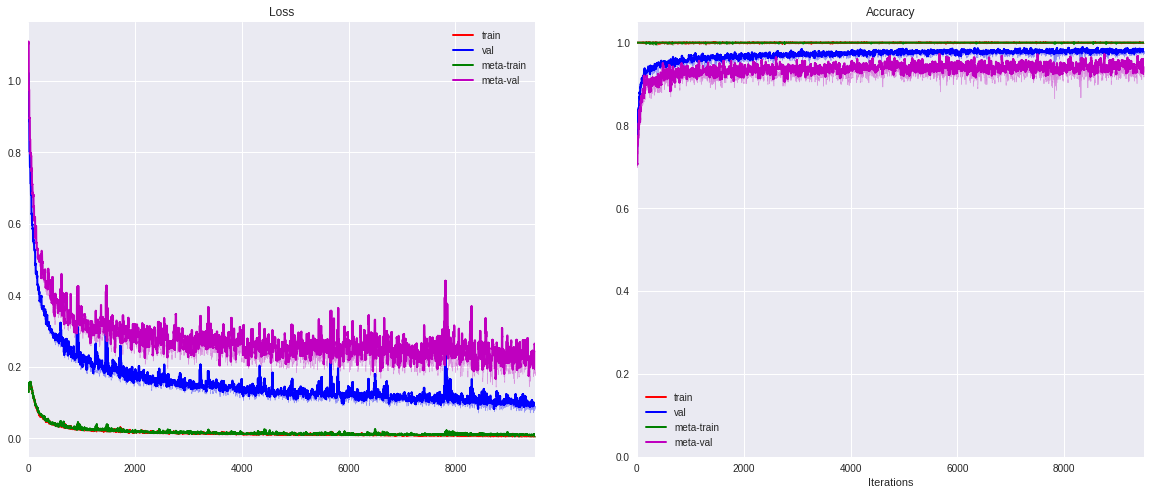

In [4]:
expdir0 = '/home/vashisht/output/maml-omniglot-5way-1shot' 
loss_dict, acc_dict = plot_multiple_runs(expdir0, 5, it_limit=9500)
print("Train Loss:  {}  Acc: {}".format(loss_dict['train'], acc_dict['train']))
print("Val Loss:  {}  Acc: {}".format(loss_dict['val'], acc_dict['val']))
print("Meta-Train Loss:  {}  Acc: {}".format(loss_dict['meta_train'], acc_dict['meta_train']))
print("Meta-Val Loss:  {}  Acc: {}".format(loss_dict['meta_val'], acc_dict['meta_val']))

## NIST MAML

* Same hyperparams as above
* Handwritten Characters: 26 lowercase + 26 uppercase + 10 digits = 62 classes
* **Train Set**: 40 characters; many instances of each
* **Val Set**: 22 characters; many instances of each

Train Loss:  0.023746251522970847  Acc: 0.999375
Val Loss:  0.1965347381104948  Acc: 0.9556250000000001
Meta-Train Loss:  0.030029788138344882  Acc: 1.0
Meta-Val Loss:  0.4161030362546444  Acc: 0.898


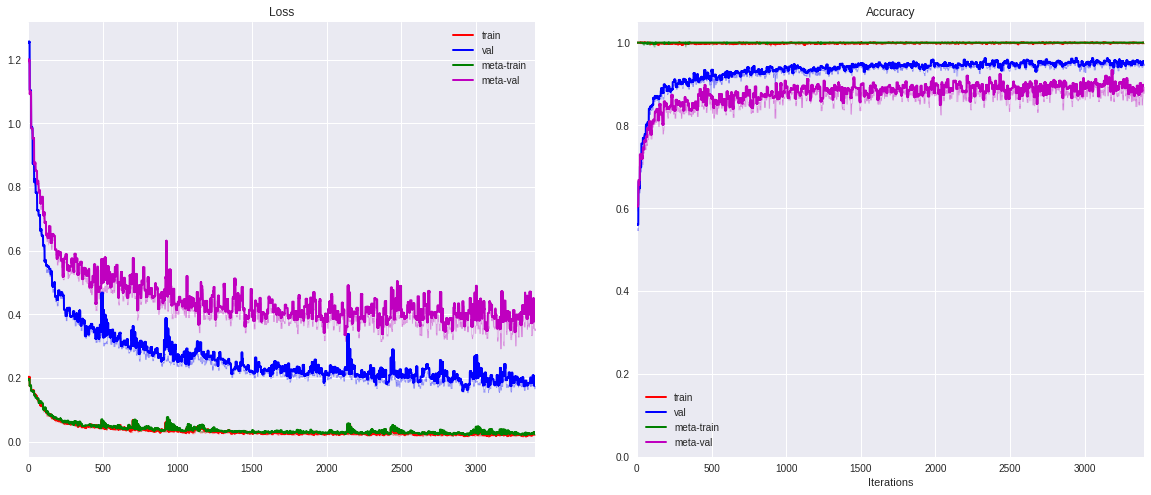

In [12]:
expdir0 = '/home/vashisht/output/maml-nist-5way-1shot' 
loss_dict, acc_dict = plot_multiple_runs(expdir0, 5, it_limit=3400)
print("Train Loss:  {}  Acc: {}".format(loss_dict['train'], acc_dict['train']))
print("Val Loss:  {}  Acc: {}".format(loss_dict['val'], acc_dict['val']))
print("Meta-Train Loss:  {}  Acc: {}".format(loss_dict['meta_train'], acc_dict['meta_train']))
print("Meta-Val Loss:  {}  Acc: {}".format(loss_dict['meta_val'], acc_dict['meta_val']))